In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Use of the `HSDetection` class

In [2]:
from hs2 import HSDetection
from probe import NeuroPixel

In [3]:
# raw data location
data_path = 'data/rawDataSample.bin'

# detection parameters
to_localize = True
cutout_start = 10
cutout_end = 30
threshold = 12
file_name = 'results/ProcessedSpikes_neuropixel'

In [4]:
Probe = NeuroPixel(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name)

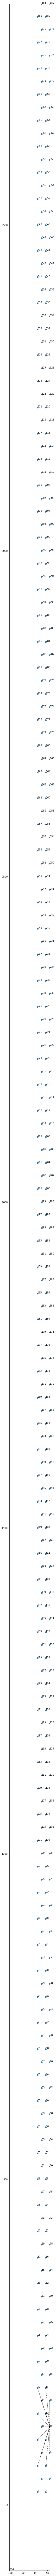

In [5]:
Probe.show()

In [6]:
H.DetectFromRaw()

IndexError: index 385 is out of bounds for axis 0 with size 385

In [ ]:
H.LoadDetected()

In [ ]:
plt.figure(figsize=(15, 10))
H.PlotTracesChannels(100)

In [ ]:
H.spikes.Shape[10].mean()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
H.PlotAll(invert=True, s=1, alpha=0.05)
plt.axis('equal');

# Use of the `HSClustering` class

In [ ]:
from hs2 import HSClustering
from sklearn.cluster import DBSCAN

In [ ]:
# Load from file
#C = Clustering(['results/ProcessedSpikes_mea1k.bin', 'results/ProcessedSpikes_mea1k.bin'], cutout_length=41)

# Or if the spikes are already in memory
# simply load from the Detection class
C = HSClustering(H)

In [ ]:
C.ShapePCA(pca_ncomponents=2, pca_whiten=True)

C.CombinedClustering(alpha=0.4, bandwidth=0.3, bin_seeding=True,
                     min_bin_freq=100, n_jobs=-1)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
C.PlotAll(invert=True, s=1, show_labels=True)
plt.title("MeanShift, bandwidth=.3, min_bin_freq=10");
plt.xlim([0,25])
plt.ylim([0,25])

In [ ]:
C.CombinedClustering(eps=0.2, alpha=0.4, clustering_algorithm=DBSCAN,
                    min_samples=5, n_jobs=-1)

In [ ]:
plt.figure(figsize=(12, 12))
C.PlotAll(invert=True, s=1)
plt.title("DBSCAN eps=0.2, min_samples=5")
# plt.xlim((1350,1600))

In [ ]:
units = (0, 1, 10, 100, 1000)

C.PlotShapes(units)

In [ ]:
C.SaveHDF5("results/f1.hdf5")